<a href="https://colab.research.google.com/github/iliaxant/HR_Extraction_from_Video/blob/main/HR_Extraction_from_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Εκτίμηση καρδιακής συχνότητας από βίντεο (πρόσωπο ή δάχτυλο) - Ψηφιακή Επεξεργασία Εικόνας**

## Εξαμηνιαία Εργασία - Ακαδημαικό έτος 2024-2025

## Ηλίας Ξανθόπουλος 58545

## GitHub Repo: https://github.com/iliaxant/HR_Extraction_from_Video
---



## Dataset: UBFC-rPPG Dataset

## S. Bobbia, R. Macwan, Y. Benezeth, A. Mansouri, J. Dubois, "Unsupervised skin tissue segmentation for remote photoplethysmography", Pattern Recognition Letters, 2017.

## **Μέρος 0**: Set-Up

1) Mounting του Google drive και φόρτωση ενός υποκειμένου της βάσης δεδομένων.

Αλλάξτε το zip_path ώστε να ταιριάζει με το directory του zip αρχείου.

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

# UBFC-RPPG Dataset 2   (subject45)
zip_path = '/content/drive/MyDrive/DIP/HR_extraction/subject45.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

# UBFC-RPPG Dataset 1 (11-gt)
zip_path = '/content/drive/MyDrive/DIP/HR_extraction/11-gt.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

print("Data unzipped successfully to /content directory.")

Data unzipped successfully to /content directory.


2) Εγκατάσταση και import βιβλιοθηκών.

In [3]:
from google.colab import drive
import zipfile
import os

import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.signal import butter, filtfilt, stft, find_peaks
from scipy.fft import fft, fftfreq

## **Μέρος 1**: Προετοιμασία Δεδομένων

1) Καθορισμός των directories όλων των δεδομένων. Τύπωση χρήσιμων πληροφοριών σχετικά με το βίντεο του υποκειμένου και τύπωση του πρώτου frame ως δείγμα.

============ Video Info ============

Resolution:       640 x 480
Frame Rate (FPS): 29.951
Frame Count:      2032
Duration:         1:07.845 (67.845s)




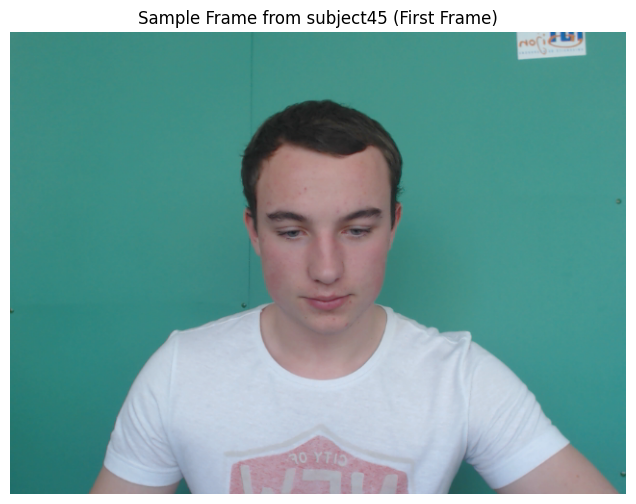

In [4]:
# UBFC-RPPG Dataset 2   (subject45)
num = '45'

subject_path = f'/content/subject{num}'
video_path = os.path.join(subject_path, 'vid.avi')
gt_path = os.path.join(subject_path, 'ground_truth.txt')


cap = cv2.VideoCapture(video_path)

ret, frame_bgr = cap.read()

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_duration_secs = frame_count / fps

cap.release()

frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

minutes = int(video_duration_secs // 60)
seconds = int(video_duration_secs % 60)
milliseconds = round((video_duration_secs - int(video_duration_secs)) * 1000)

video_duration_full_time = f"{minutes}:{seconds:02d}.{milliseconds:03d}"

print("============ Video Info ============\n")

print(f"Resolution:       {width} x {height}")
print(f"Frame Rate (FPS): {fps:.3f}")
print(f"Frame Count:      {frame_count}")
print(f"Duration:         {video_duration_full_time} ({video_duration_secs:.3f}s)\n")

print("====================================\n")

plt.figure(figsize=(8, 6))
plt.imshow(frame_rgb)
plt.title(f"Sample Frame from subject{num} (First Frame)")
plt.axis('off')
plt.show()

2) Τύπωση όλων των χρήσιμων πληροφοριών για το Ground Truth. Σχεδίαση της γραφικής παράστασης του PPG σήματος και του HR για ένα καθορισμένο χρονικό παράθυρο.

========= Ground Truth Info =========

PPG signal/Time/HR samples: 2032
Time range: 0.000s to 67.828s
Sampling rate (estimated): 29.943 Hz

PPG signal (first 10 samples): [-0.804 -0.898 -0.851 -0.772 -0.873 -1.036 -1.276 -1.452 -1.496 -1.464]
PPG signal mean: -0.000
PPG signal Standard Deviation: 0.985

Time in seconds (first 10 samples): [0.    0.033 0.066 0.099 0.132 0.165 0.202 0.233 0.275 0.297]
Difference of sampling times (first 10 values): [0.033 0.033 0.033 0.033 0.033 0.037 0.031 0.042 0.022 0.035]
Difference of sampling times mean: 0.033
Difference of sampling times Standard Deviation: 0.008

Time difference of PPG peaks (first 10 samples): [0.619 0.564 0.541 0.557 0.538 0.567 0.531 0.542 0.525 0.532]
Instantaneous Heart Rates (Hz) (first 10 samples): [1.616 1.773 1.848 1.795 1.859 1.764 1.883 1.845 1.905 1.88 ]
Instantaneous Heart Rates (bpm) (first 10 samples): [ 96.931 106.383 110.906 107.72  111.524 105.82  112.994 110.701 114.286
 112.782]

HR in bpm (first 10 samples): 

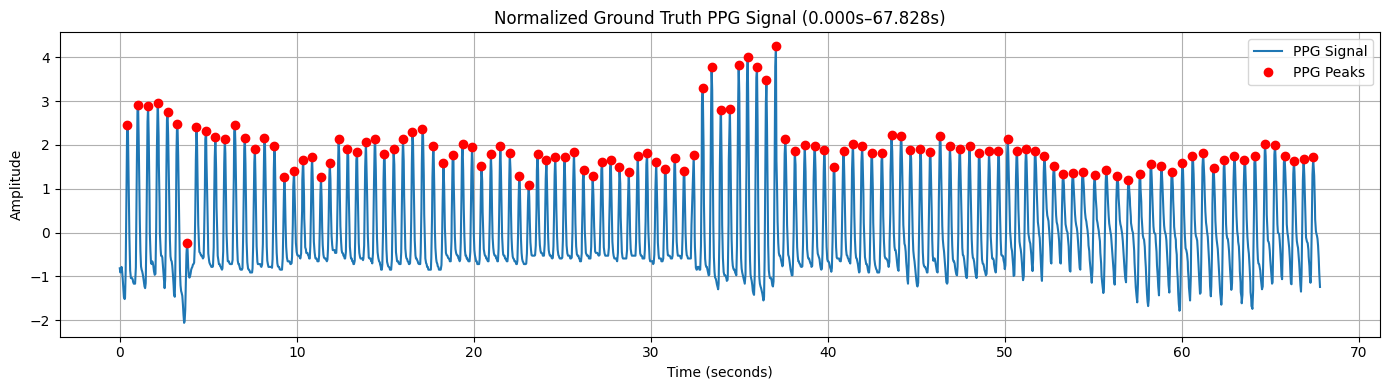

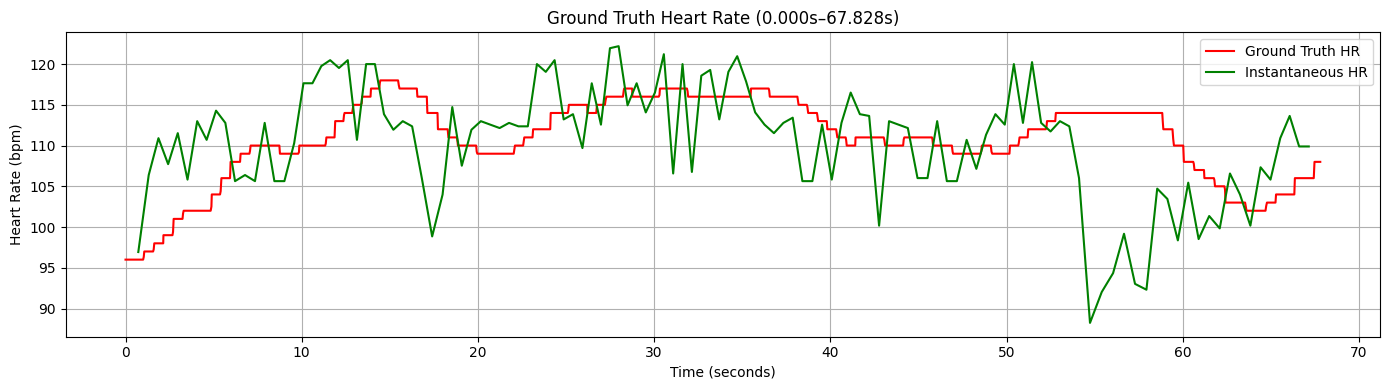

In [5]:
# UBFC-RPPG Dataset 2   (subject45)
gt_data = np.loadtxt(gt_path)
gt_ppg = gt_data[0, :]
gt_hr = gt_data[1, :]
gt_time = gt_data[2, :]


# Input start time and duration (in seconds) for PPG signal and HR plot.
# ------------------------------------------------
start_time = 0
segment_duration = gt_time[-1]    # Signal lasts gt_time[-1] seconds.
# ------------------------------------------------


end_time = start_time + segment_duration
start_time = np.clip(start_time, 0, gt_time[-1])
end_time = np.clip(end_time, 0, gt_time[-1])

start_samp = np.searchsorted(gt_time, start_time)
end_samp = np.searchsorted(gt_time, end_time)

gt_ppg_norm = (gt_ppg - np.mean(gt_ppg)) / np.std(gt_ppg)
gt_ppg_peaks, gt_ppg_peaks_props = find_peaks(gt_ppg_norm,prominence=0.5)
gt_ppg_peak_times = gt_time[gt_ppg_peaks]

gt_samp_time_diff = np.diff(gt_time)
gt_peak_time_diff = np.diff(gt_ppg_peak_times)

instantaneous_hr_hz = 1 / gt_peak_time_diff
instantaneous_hr_bpm = instantaneous_hr_hz * 60

gt_ppg_peaks_filt = gt_ppg_peaks[
    (gt_time[gt_ppg_peaks] >= start_time) &
    (gt_time[gt_ppg_peaks] <= end_time)
]

instantaneous_hr_times = (gt_ppg_peak_times[1:] + gt_ppg_peak_times[:-1]) / 2
hr_time_mask = (instantaneous_hr_times >= start_time) & (instantaneous_hr_times <= end_time)
instantaneous_hr_times_filt = instantaneous_hr_times[hr_time_mask]
instantaneous_hr_bpm_filt = instantaneous_hr_bpm[hr_time_mask]


print("========= Ground Truth Info =========\n")

print(f"PPG signal/Time/HR samples: {len(gt_ppg)}")
print(f"Time range: {gt_time[0]:.3f}s to {gt_time[-1]:.3f}s")
print(f"Sampling rate (estimated): {1/np.mean(np.diff(gt_time)):.3f} Hz\n")

print(f"PPG signal (first 10 samples): {np.round(gt_ppg[:10], 3)}")
print(f"PPG signal mean: {np.mean(gt_ppg):.3f}")
print(f"PPG signal Standard Deviation: {np.std(gt_ppg):.3f}\n")

print(f"Time in seconds (first 10 samples): {gt_time[:10]}")
print(f"Difference of sampling times (first 10 values): {gt_samp_time_diff[:10]}")
print(f"Difference of sampling times mean: {np.mean(gt_samp_time_diff):.3f}")
print(f"Difference of sampling times Standard Deviation: {np.std(gt_samp_time_diff):.3f}\n")

print(f"Time difference of PPG peaks (first 10 samples): {gt_peak_time_diff[:10]}")
print(f"Instantaneous Heart Rates (Hz) (first 10 samples): {np.round(instantaneous_hr_hz[:10], 3)}")
print(f"Instantaneous Heart Rates (bpm) (first 10 samples): {np.round(instantaneous_hr_bpm[:10], 3)}\n")

print(f"HR in bpm (first 10 samples): {gt_hr[:10].astype(int)}")
print(f"HR mean: {np.mean(gt_hr):.3f}")
print(f"HR Standard Deviation: {np.std(gt_hr):.3f}\n")

print("=====================================\n")


plt.figure(figsize=(14, 4))
plt.plot(gt_time[start_samp:end_samp], gt_ppg_norm[start_samp:end_samp],
         label="PPG Signal")
plt.plot(gt_time[gt_ppg_peaks_filt], gt_ppg_norm[gt_ppg_peaks_filt], 'o',
         color = 'r', label="PPG Peaks")
plt.title(f"Normalized Ground Truth PPG Signal ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(gt_time[start_samp:end_samp], gt_hr[start_samp:end_samp], color='r',
         label = 'Ground Truth HR')
plt.plot(instantaneous_hr_times_filt, instantaneous_hr_bpm_filt, color='g',
         label = 'Instantaneous HR')
plt.title(f"Ground Truth Heart Rate ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Heart Rate (bpm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Μέρος 2**: Εκτίμηση καρδιακού ρυθμού

Πρώτο βήμα της εκτιμήσης του καρδιακού ρυθμού είναι η εύρεση της περιοχής ενδιαφέροντος (Region of Interest - ROI). Η περιοχή ενδιαφέροντος στην συγκεκριμένη εφαρμογή είναι το μέτωπου του υποκειμένου. Οπότε ο εντοπισμός της περιοχής αυτής μπορεί να γίνει με 2 τρόπους:


*   Χειροκίνητα
*   Ανίχνευση προσώπου κατά Viola και
Jones (Haar Cascades)

Παρακάτω γίνεται πρώτα η εκτίμηση του HR με χειροκίνητα ορισμένη ROI και μετά με ορισμένη από ανίχνευση προσώπου.

### **1ος Τρόπος:** Χειροκίνητος ορισμός της ROI

Χειροκίνητος ορισμός μίας περιοχής ενδιαφέροντος για όλη την διάρκεια του video.

(Προϋποθέτει ότι το υποκείμενο του video παράμενει ακίνητο.)

1) Εύρεση του Region of Interest (ROI) για κάθε frame ενός ορισμένου χρονικού παραθύρου του βίντεο. Υπολογισμός για κάθε frame της μέσης έντασης ενός χρωματικού καναλιού (πράσινο - G) μέσα στην ROI (Spatial Averaging) και αναπαράσταση της σε γράφημα για το συγκεκριμένο χρονικό διάστημα.

In [6]:
# Input start time and duration (in seconds) for Manual ROI Mean Channel intensity plot.
# Input ROI coordinates for Mean Channel Intensity calculation and which Channel.
# ------------------------------------------------

start_time = 0
segment_duration = video_duration_secs  # Signal lasts video_duration_secs seconds.

# UBFC-RPPG Dataset 2   (subject45)
x1, y1 = 305, 141
x2, y2 = 347, 175
channel = 1  # 0: Blue, 1: Green, 2: Red  (BGR colorspace)

# ------------------------------------------------


def mean_intensity_manual_roi(vid_path, start_fr, end_fr, roi_coords, chan):

    roi_frames = []
    roi_means = []

    cap = cv2.VideoCapture(vid_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_fr)

    for _ in tqdm(range(start_fr, end_fr)):
        ret, frame = cap.read()
        if not ret:
            break

        roi = frame[roi_coords[1]:roi_coords[3], roi_coords[0]:roi_coords[2], :].copy()
        roi_frames.append(roi.copy())

        roi = roi[:,:, chan]
        mean_val = np.mean(roi)
        roi_means.append(mean_val)

    cap.release()

    return roi_means, roi_frames


end_time = start_time + segment_duration
start_time = np.clip(start_time, 0, video_duration_secs)
end_time = np.clip(end_time, 0, video_duration_secs)

start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

roi_coordinates = [x1, y1, x2, y2]
print(f'Manual ROI coordinates: Top Right ({x1},{y1}) - Bottom Left ({x2},{y2})')
print(f'Manual ROI size: {x2-x1} x {y2-y1}\n')
print('Calculating ROI Mean Channel Intensity in the respective video frames...\n')

roi_means_manual, roi_frames_manual = mean_intensity_manual_roi(video_path,
                                                                start_frame,
                                                                end_frame,
                                                                roi_coordinates,
                                                                channel
                                                                )

print('\n\nCalculations completed!')

Manual ROI coordinates: Top Right (305,141) - Bottom Left (347,175)
Manual ROI size: 42 x 34

Calculating ROI Mean Channel Intensity in the respective video frames...



100%|██████████| 2032/2032 [00:11<00:00, 173.53it/s]



Calculations completed!


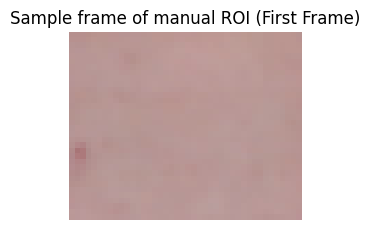

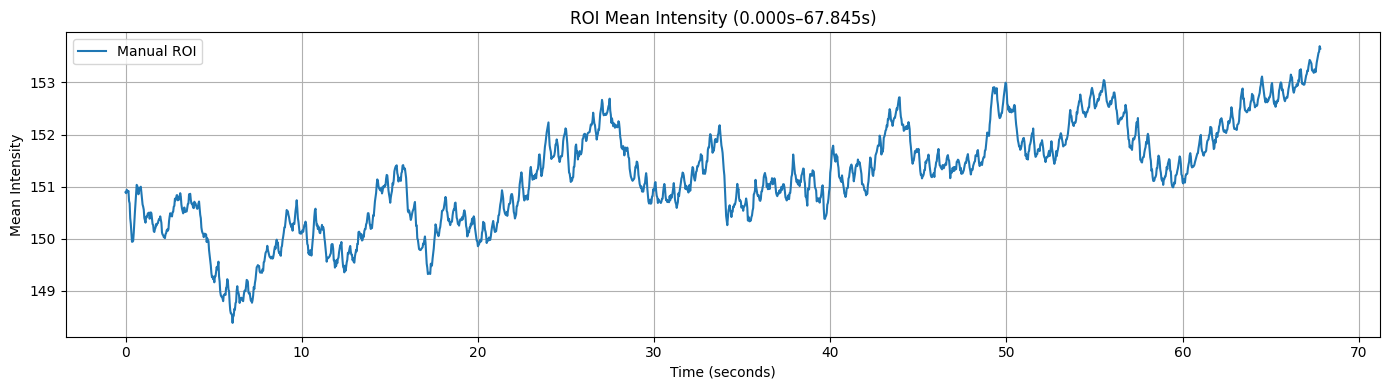

In [7]:
plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(roi_frames_manual[0], cv2.COLOR_BGR2RGB))
plt.title(f"Sample frame of manual ROI (First Frame)")
plt.axis('off')
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(np.arange(start_frame, start_frame + len(roi_means_manual)) / fps,
         roi_means_manual, label="Manual ROI")
plt.title(f"ROI Mean Intensity ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

2) Κανονικοποίηση (=> μ=0, σ=1) του σήματος μέσης έντασης για την αφαίρεση της DC συνιστώσας.

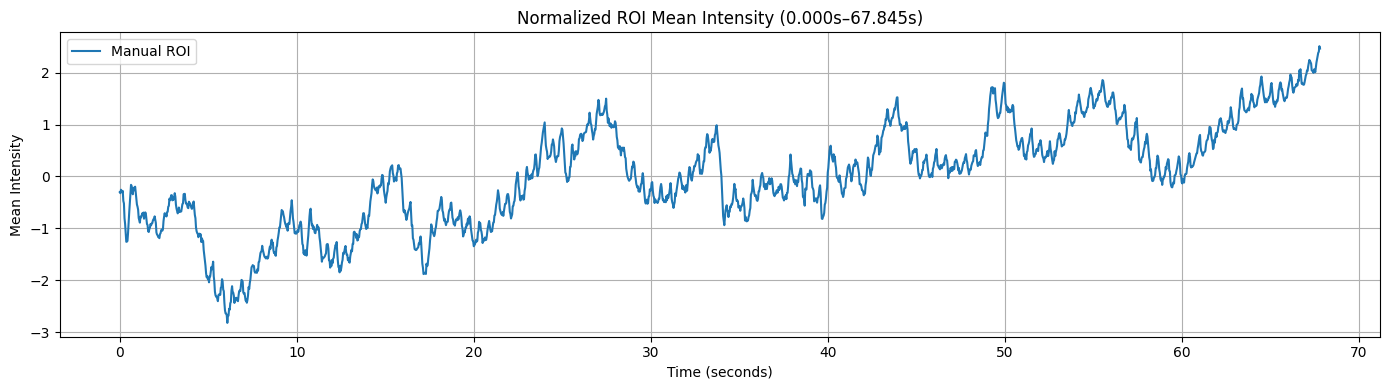

In [8]:
roi_mean_manual_norm = (roi_means_manual - np.mean(roi_means_manual)) / np.std(roi_means_manual)

plt.figure(figsize=(14, 4))
plt.plot(np.arange(int(start_time * fps), int(start_time * fps) + len(roi_means_manual)) / fps,
         roi_mean_manual_norm, label="Manual ROI")
plt.title(f"Normalized ROI Mean Intensity ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

3) Εφαρμογή Butterworth Ζωνοπερατού φίλτρου για την απομόνωση των ανθρώπινων καρδιακών συχνοτήτων.

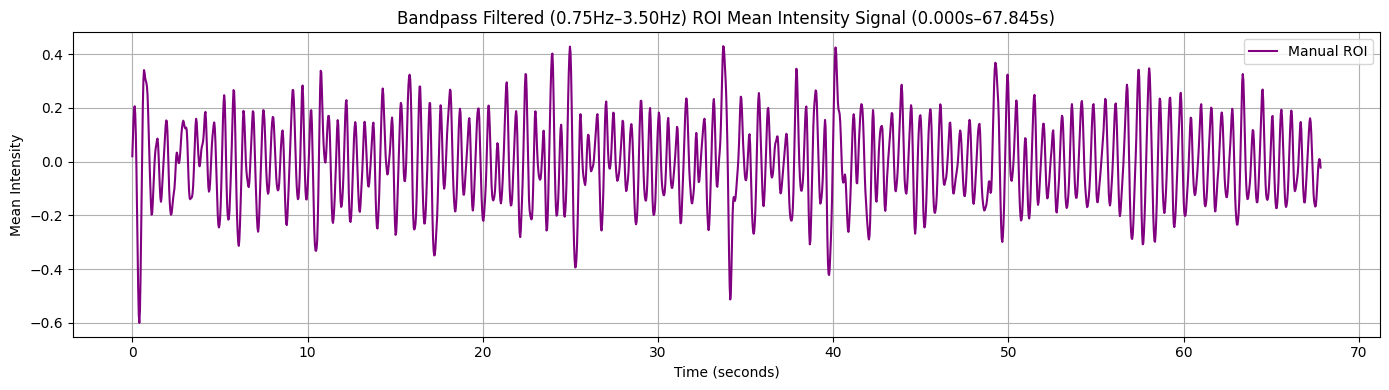

In [9]:
# Input the cutoff frequencies and the order of the bandpass filter.
# ----------------------
lowcut = 0.75
highcut = 3.5

filt_order = 1
# ----------------------


def bandpass_filter(data, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)


filtered_manual = bandpass_filter(roi_mean_manual_norm, lowcut, highcut, fps, filt_order)

plt.figure(figsize=(14, 4))
plt.plot(np.arange(int(start_time * fps), int(start_time * fps) + len(roi_mean_manual_norm)) / fps,
         filtered_manual, color='purple', label="Manual ROI")
plt.title(f"Bandpass Filtered ({lowcut:.2f}Hz–{highcut:.2f}Hz) ROI Mean Intensity Signal ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

4) Εφαρμογή Short-Time-Fourier-Transform στο φιλτραρισμένο σήμα και οπτικοποίηση του μετασχηματισμού μέσω Spectogram. Εξαγαγωγή της κυρίαρχης συχνότητας από το κάθε χρονικό παράθυρο, μετατροπή από Hz σε bpm και αναπαράσταση σε γράφημα συγκριτικά με το HR του Ground Truth.

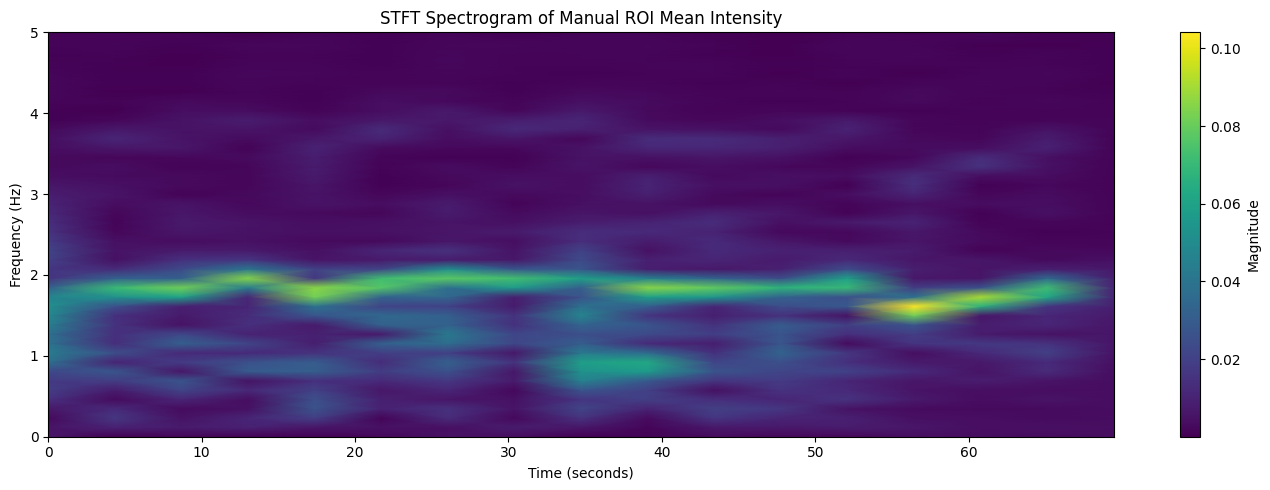

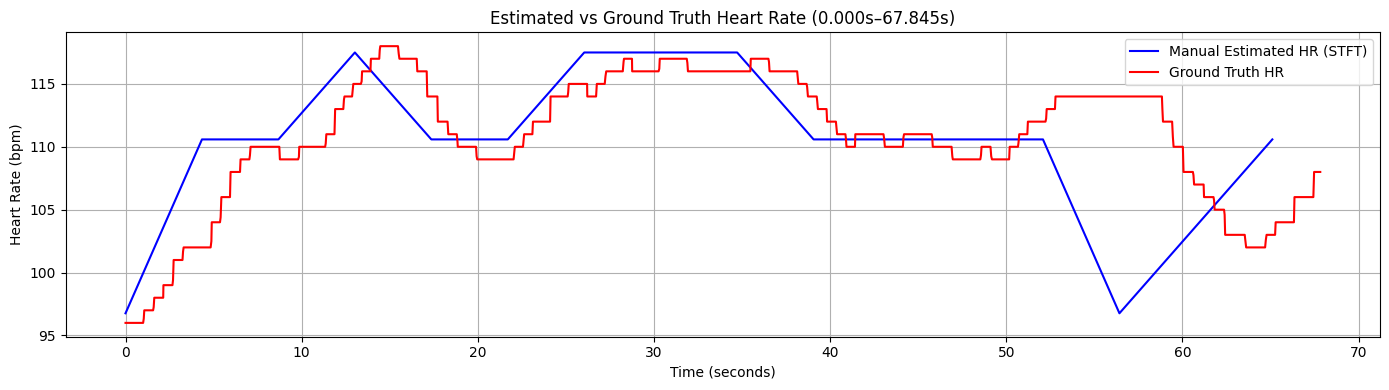

In [10]:
# Input the window parameters for the STFT
# ----------------------
window_size = 260
overlap_ratio = 0.5
# ----------------------



f_manual, t_manual, Zxx_manual = stft(filtered_manual,
                                      fs=fps,
                                      nperseg=window_size,
                                      noverlap= int(overlap_ratio * window_size),
                                      # boundary=None,
                                      # padded=False,
                                      )

t_manual = t_manual + start_time
magnitude_manual = np.abs(Zxx_manual)
dominant_freqs_manual = f_manual[np.argmax(magnitude_manual, axis=0)]
dominant_hr_manual = dominant_freqs_manual * 60  # Hz to bpm

valid_idx = t_manual <= end_time
t_manual_valid = t_manual[valid_idx]
dominant_hr_manual_valid = dominant_hr_manual[valid_idx]

start_samp = np.searchsorted(gt_time, start_time)
end_samp = np.searchsorted(gt_time, end_time)

plt.figure(figsize=(14, 5))
plt.pcolormesh(t_manual, f_manual, magnitude_manual, shading='gouraud')
plt.title("STFT Spectrogram of Manual ROI Mean Intensity")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='Magnitude')
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(t_manual_valid, dominant_hr_manual_valid, color='blue', label='Manual Estimated HR (STFT)')
# plt.plot(t_manual, dominant_hr_manual, color='blue', label='Estimated HR (STFT)')
plt.plot(gt_time[start_samp:end_samp], gt_hr[start_samp:end_samp], color='red', label='Ground Truth HR')
plt.title(f"Estimated vs Ground Truth Heart Rate ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Heart Rate (bpm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### **2ος Τρόπος:** Ορισμός ROI μέσω ανίχνευση προσώπου κατά Viola και Jones (Haar Cascades)

Εφαρμογή ανίχνευσης προσώπου κατά Viola και
Jones και επιλογή μέρους της εξόδου της ως ROI.

1) Εύρεση του Region of Interest (ROI) για κάθε frame ενός ορισμένου χρονικού παραθύρου του βίντεο. Υπολογισμός για κάθε frame της μέσης έντασης ενός χρωματικού καναλιού (πράσινο - G) μέσα στην ROI (Spatial Averaging) και αναπαράσταση της σε γράφημα για το συγκεκριμένο χρονικό διάστημα.

In [11]:
# Input start time and duration (in seconds) for Haar ROI Mean Channel intensity plot.
# Input the channel the calculations will be performed on.
# ----------------------

start_time = 0
segment_duration = video_duration_secs    # Signal lasts video_duration_secs seconds.

channel = 1  # 0: Blue, 1: Green, 2: Red  (BGR colorspace)

# ----------------------


def mean_intensity_haar_roi(vid_path, start_fr, end_fr, chan):

    face_frames = []
    roi_means = []
    roi_frames =[]

    roi_x =[]
    roi_y =[]
    roi_w =[]
    roi_h =[]

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    cap = cv2.VideoCapture(vid_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_fr)

    for _ in tqdm(range(start_fr, end_fr)):
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3, minSize=(60, 60))

        roi = []
        if len(faces) > 0:
            x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
            face_frames.append(frame[y:y+h,x:x+w,:].copy())

            roi_x, roi_y, roi_w, roi_h = x+int(w*0.35), y+int(w*0.05), int(w*0.3), int(h*0.15)
        else:
            face_frames.append(None)
            roi = frame[roi_y:roi_y+roi_h,roi_x:roi_x+roi_w,:].copy()
            roi_frames.append(roi.copy())


        roi = frame[roi_y:roi_y+roi_h,roi_x:roi_x+roi_w,:].copy()
        roi_frames.append(roi.copy())
        roi = roi[:,:, chan]
        mean_val = np.mean(roi)
        roi_means.append(mean_val)

    cap.release()

    return face_frames, roi_means, roi_frames


end_time = start_time + segment_duration
start_time = np.clip(start_time, 0, video_duration_secs)
end_time = np.clip(end_time, 0, video_duration_secs)

start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

print('Calculating ROI Mean Channel Intensity in the respective video frames...\n')

face_frames_haar, roi_means_haar, roi_frames_haar = mean_intensity_haar_roi(video_path,
                                                                            start_frame,
                                                                            end_frame,
                                                                            channel)
print('\n\nCalculations completed!')

Calculating ROI Mean Channel Intensity in the respective video frames...



100%|██████████| 2032/2032 [01:24<00:00, 23.94it/s]



Calculations completed!


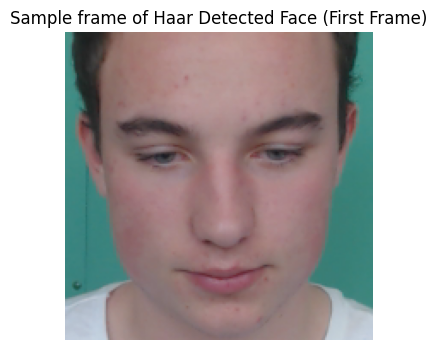

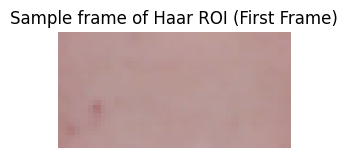

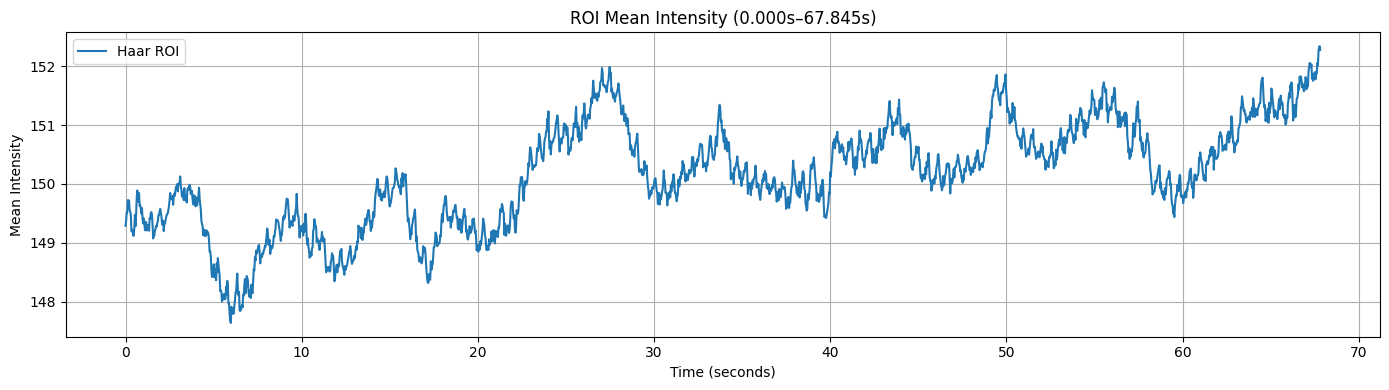

In [12]:
plt.figure(figsize=(6, 4))
plt.imshow(cv2.cvtColor(face_frames_haar[0], cv2.COLOR_BGR2RGB))
plt.title(f"Sample frame of Haar Detected Face (First Frame)")
plt.axis('off')
plt.show()

plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(roi_frames_haar[0], cv2.COLOR_BGR2RGB))
plt.title(f"Sample frame of Haar ROI (First Frame)")
plt.axis('off')
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(np.arange(start_frame, start_frame + len(roi_means_haar)) / fps,
         roi_means_haar, label="Haar ROI")
plt.title(f"ROI Mean Intensity ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

2) Κανονικοποίηση (=> μ=0, σ=1) του σήματος μέσης έντασης για την αφαίρεση της DC συνιστώσας.

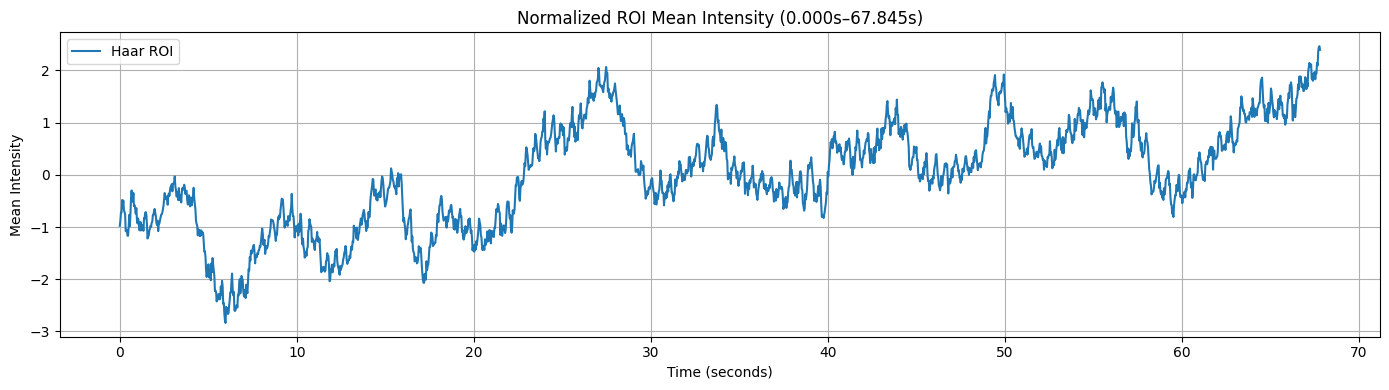

In [13]:
roi_mean_haar_norm = (roi_means_haar - np.mean(roi_means_haar)) / np.std(roi_means_haar)

plt.figure(figsize=(14, 4))
plt.plot(np.arange(int(start_time * fps), int(start_time * fps) + len(roi_means_haar)) / fps,
         roi_mean_haar_norm, label="Haar ROI")
plt.title(f"Normalized ROI Mean Intensity ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

3) Εφαρμογή Butterworth Ζωνοπερατού φίλτρου για την απομόνωση των δυνατών καρδιακών συχνοτήτων.

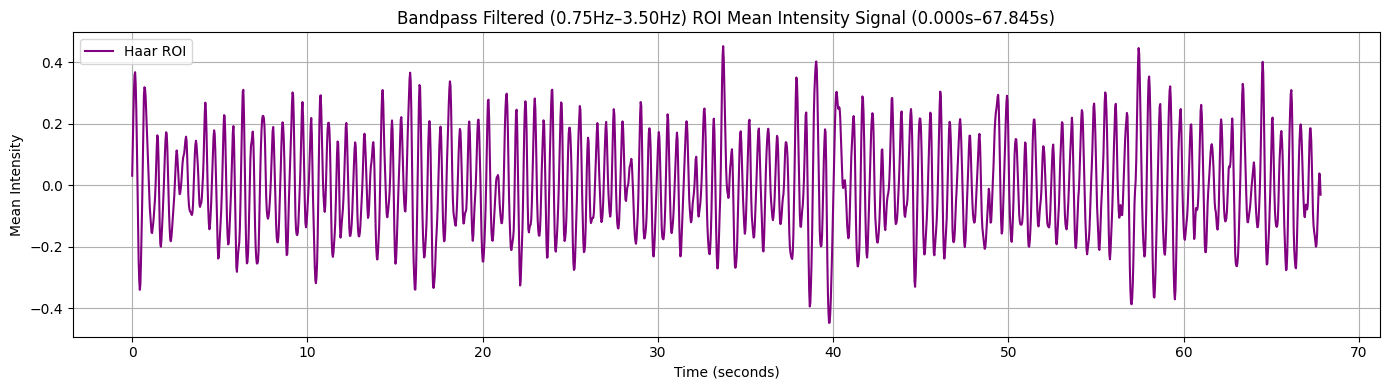

In [14]:
# Input the cutoff frequencies and the order of the bandpass filter.
# ----------------------
lowcut = 0.75
highcut = 3.5

filt_order=1
# ----------------------

filtered_haar = bandpass_filter(roi_mean_haar_norm, lowcut, highcut, fps, filt_order)

plt.figure(figsize=(14, 4))
plt.plot(np.arange(int(start_time * fps), int(start_time * fps) + len(roi_mean_haar_norm)) / fps,
         filtered_haar, color='purple', label="Haar ROI")
plt.title(f"Bandpass Filtered ({lowcut:.2f}Hz–{highcut:.2f}Hz) ROI Mean Intensity Signal ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

4) Εφαρμογή Short-Time-Fourier-Transform στο φιλτραρισμένο σήμα και οπτικοποίηση του μετασχηματισμού μέσω Spectogram. Εξαγαγωγή της κυρίαρχης συχνότητας από το κάθε χρονικό παράθυρο, μετατροπή από Hz σε bpm και αναπαράσταση σε γράφημα συγκριτικά με το HR του Ground Truth.

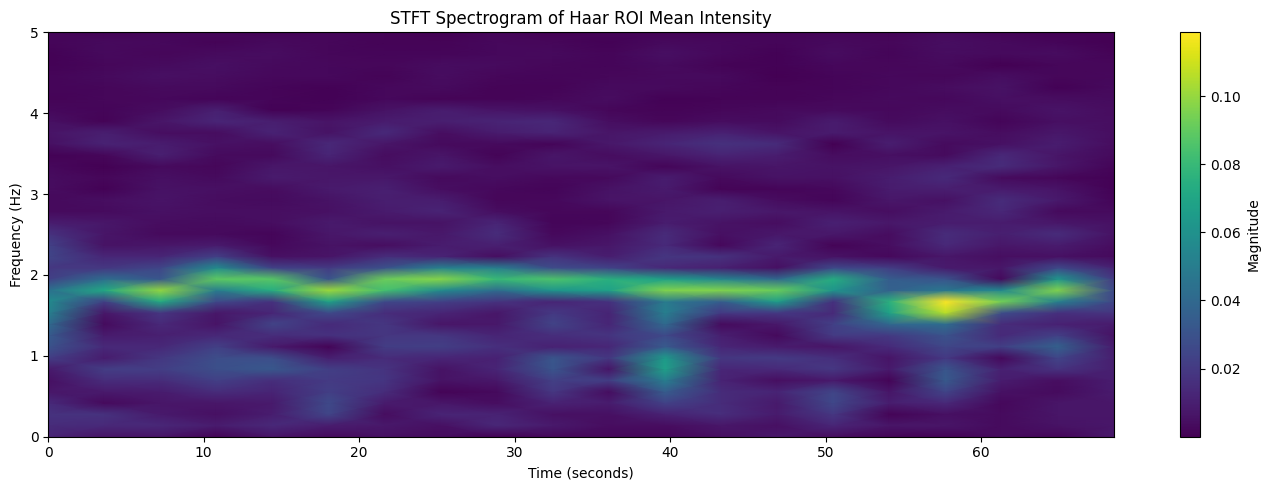

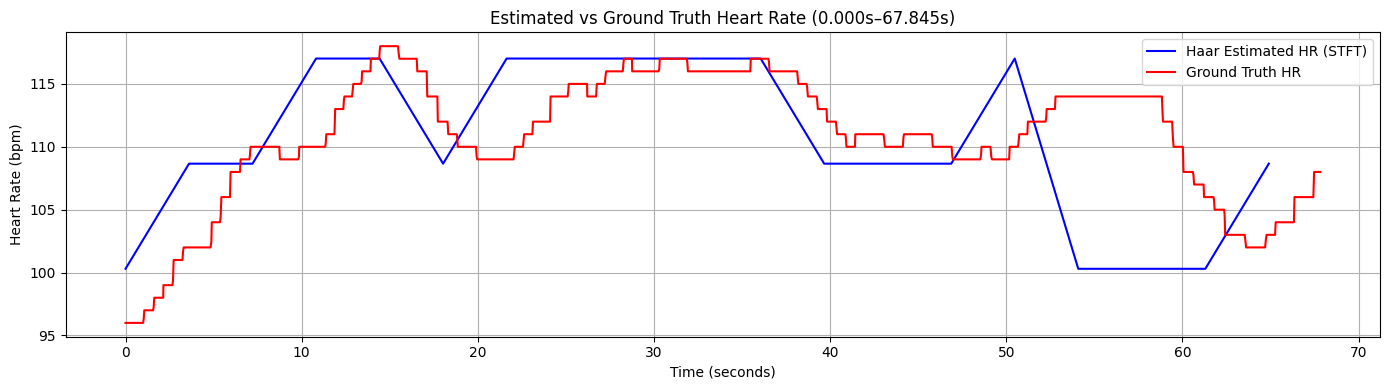

In [15]:
# Input the window parameters for the STFT
# ----------------------
window_size = 215  # 260 is great as well
overlap_ratio = 0.5
# ----------------------



f_haar, t_haar, Zxx_haar = stft(filtered_haar,
                                fs=fps,
                                nperseg=window_size,
                                noverlap= int(overlap_ratio * window_size),
                                # boundary=None,
                                # padded=False,
                                )

t_haar = t_haar + start_time
magnitude_haar = np.abs(Zxx_haar)
dominant_freqs_haar = f_haar[np.argmax(magnitude_haar, axis=0)]
dominant_hr_haar = dominant_freqs_haar * 60  # Hz to bpm

valid_idx = t_haar <= end_time
t_haar_valid = t_haar[valid_idx]
dominant_hr_haar_valid = dominant_hr_haar[valid_idx]

start_samp = np.searchsorted(gt_time, start_time)
end_samp = np.searchsorted(gt_time, end_time)

plt.figure(figsize=(14, 5))
plt.pcolormesh(t_haar, f_haar, magnitude_haar, shading='gouraud')
plt.title("STFT Spectrogram of Haar ROI Mean Intensity")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='Magnitude')
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(t_haar_valid, dominant_hr_haar_valid, color='blue', label='Haar Estimated HR (STFT)')
# plt.plot(t_haar, dominant_hr_haar, color='blue', label='Estimated HR (STFT)')
plt.plot(gt_time[start_samp:end_samp], gt_hr[start_samp:end_samp], color='red', label='Ground Truth HR')
plt.title(f"Estimated vs Ground Truth Heart Rate ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Heart Rate (bpm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Μέρος 4**: Συμπληρωματικά

### **1. Ορθότητα Ground truth**

Για το subject45 του Dataset2 υπάρχει και στις 2 υλοποιήσεις μία μεγάλη πτώση της υπολογισμένης καρδιακής συχνότητας περίπου στο διάστημα των 53-58sec, η οποία αποκλίνει πολύ απο εκείνη του Ground Truth. Η ίδια απόκλιση συγκριτικά με το Ground Truth φαίνεται και από τις αντίστοιχες τιμές του στιγμιαίου HR, οι οποίες λήφθηκαν από το PPG του Ground Truth. Αυτό δημιουργεί υποψίες σχετικά με την ορθότητα των ενδέιξεων του οξύμετρου ή PPG για την συγκεκριμένη χρονική περίοδο και επομένως απαιτείται επαλήθευση.

Έστω λοιπόν ότι το Ground Truth στο διάστημα [53s,58s] είναι όντως σωστό και άρα η καρδιακή συχνότητα παραμένει σταθερή στα 114 bpm. Εφόσον το HR παραμένει σταθερό και επομένως η συχνότητα του PPG είναι χρονικά αμετάβλητη, μπορούμε να εφαρμόσουμε Fast Fourier Transform στο διάστημα [53s,58s] και να εξάγουμε την ίδια ακριβώς συχνότητα.

Ακολουθούμε την ίδια διαδικασία των προηγούμενων *Μερών*, μόνο που όλα τα βήματα αφορούν το time window 53s-58s. Χρησιμοποιείται η εύρεση ROI με ανίχνευση προσώπου κατα Viola και Jones, αλλά τα ίδια αποτελέσματα εξάγονται και για το χειροκίνητα ορισμένο ROI.

1) Εύρεση του Region of Interest (ROI) για κάθε frame του διαστήματος [53s,58s] του βίντεο. Υπολογισμός για κάθε frame της μέσης έντασης ενός χρωματικού καναλιού (πράσινο - G) μέσα στην ROI (Spatial Averaging) και αναπαράστασή της σε γράφημα για το συγκεκριμένο χρονικό διάστημα.

In [16]:
start_time = 53
segment_duration = 5
channel = 1  # 1: Green

end_time = start_time + segment_duration
start_time = np.clip(start_time, 0, video_duration_secs)
end_time = np.clip(end_time, 0, video_duration_secs)

start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

print('Calculating ROI Mean Channel Intensity in the respective video frames...\n')

face_frames_test, roi_means_test, roi_frames_test = mean_intensity_haar_roi(video_path,
                                                                            start_frame,
                                                                            end_frame,
                                                                            channel)

print('\n\nCalculations completed!')

Calculating ROI Mean Channel Intensity in the respective video frames...



100%|██████████| 150/150 [00:05<00:00, 26.58it/s]



Calculations completed!


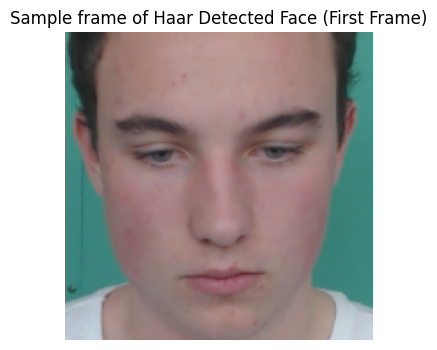

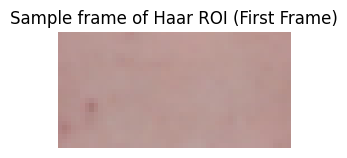

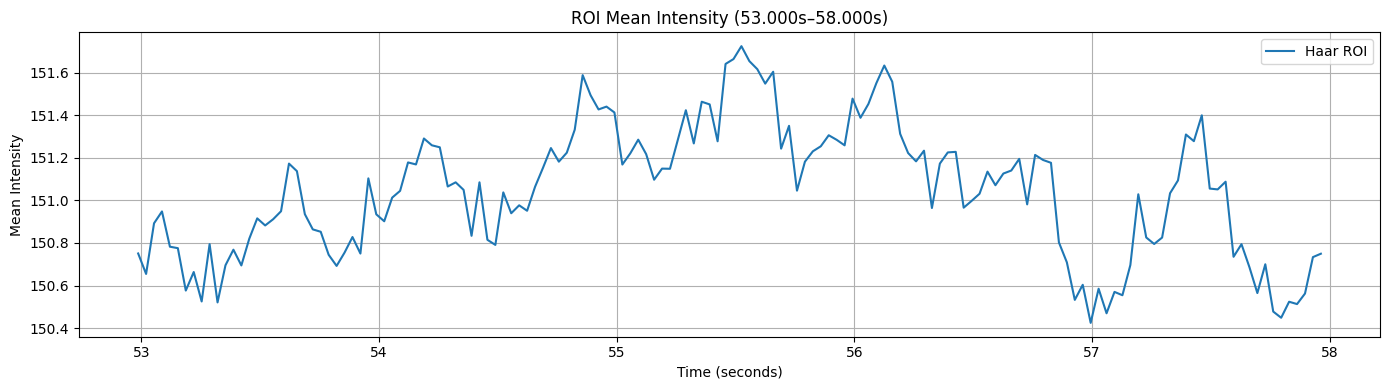

In [17]:
plt.figure(figsize=(6, 4))
plt.imshow(cv2.cvtColor(face_frames_test[0], cv2.COLOR_BGR2RGB))
plt.title(f"Sample frame of Haar Detected Face (First Frame)")
plt.axis('off')
plt.show()

plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(roi_frames_test[0], cv2.COLOR_BGR2RGB))
plt.title(f"Sample frame of Haar ROI (First Frame)")
plt.axis('off')
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(np.arange(start_frame, start_frame + len(roi_means_test)) / fps,
         roi_means_test, label="Haar ROI")
plt.title(f"ROI Mean Intensity ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

2) Κανονικοποίηση (=> μ=0, σ=1) του σήματος μέσης έντασης για την αφαίρεση της DC συνιστώσας.

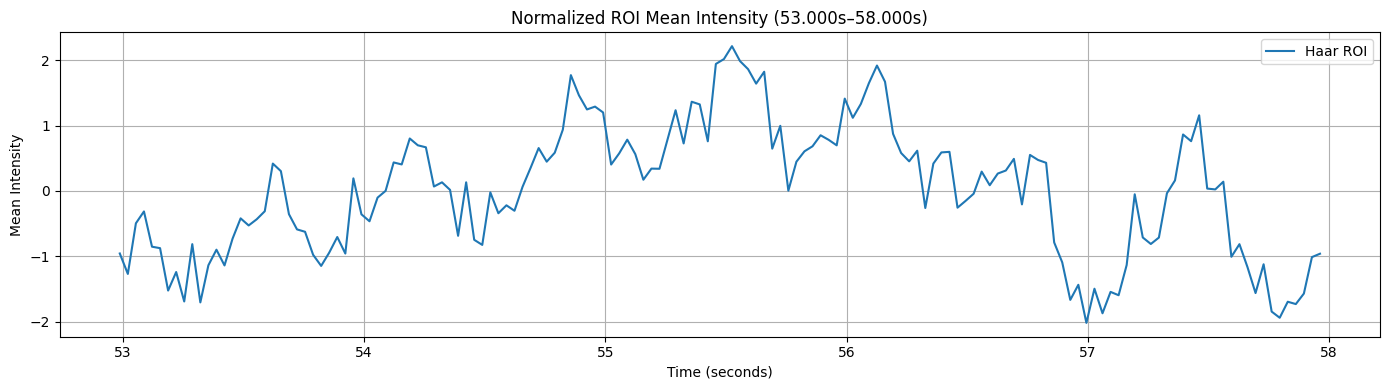

In [18]:
roi_mean_test_norm = (roi_means_test - np.mean(roi_means_test)) / np.std(roi_means_test)

plt.figure(figsize=(14, 4))
plt.plot(np.arange(int(start_time * fps), int(start_time * fps) + len(roi_means_test)) / fps,
         roi_mean_test_norm, label="Haar ROI")
plt.title(f"Normalized ROI Mean Intensity ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

3) Εφαρμογή Butterworth Ζωνοπερατού φίλτρου για την απομόνωση των ανθρώπινων καρδιακών συχνοτήτων.

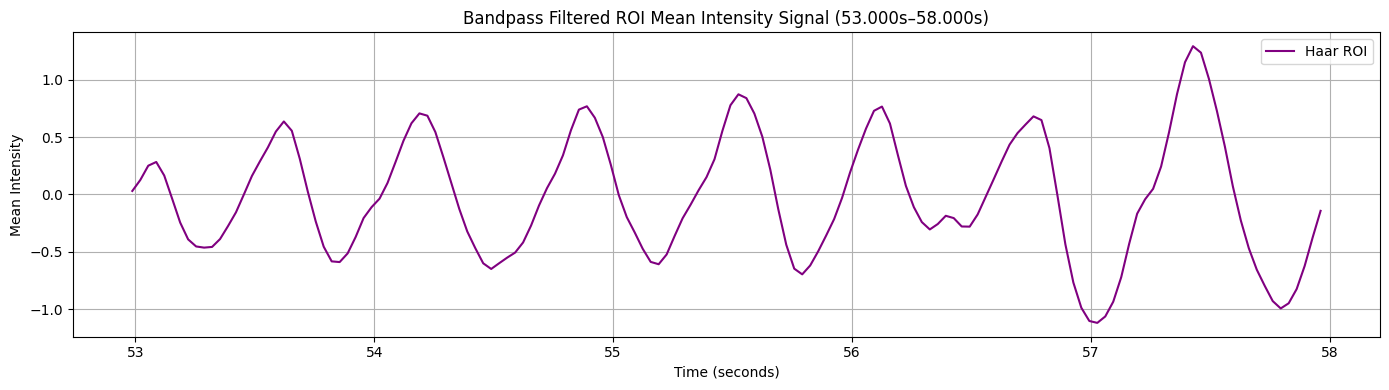

In [19]:
lowcut = 0.75
highcut = 3.5
filt_order=1

filtered_test = bandpass_filter(roi_mean_test_norm, lowcut, highcut, fps, filt_order)

plt.figure(figsize=(14, 4))
plt.plot(np.arange(int(start_time * fps), int(start_time * fps) + len(roi_mean_test_norm)) / fps,
         filtered_test, color='purple', label="Haar ROI")
plt.title(f"Bandpass Filtered ROI Mean Intensity Signal ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

4) Εφαρμογή Fast-Fourier-Transform στο φιλτραρισμένο σήμα. Εξαγαγωγή της κυρίαρχης συχνότητας, μετατροπή από Hz σε bpm και σύγκριση με το HR του Ground Truth.

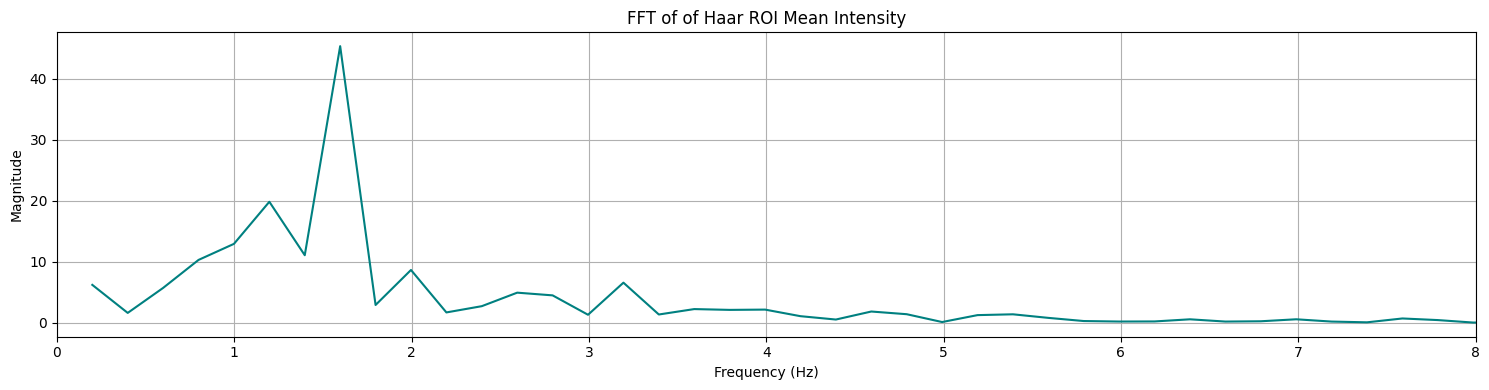


Estimated Heart Rate: 95.84 bpm
Ground Truth Heart Rate: 114.0 bpm



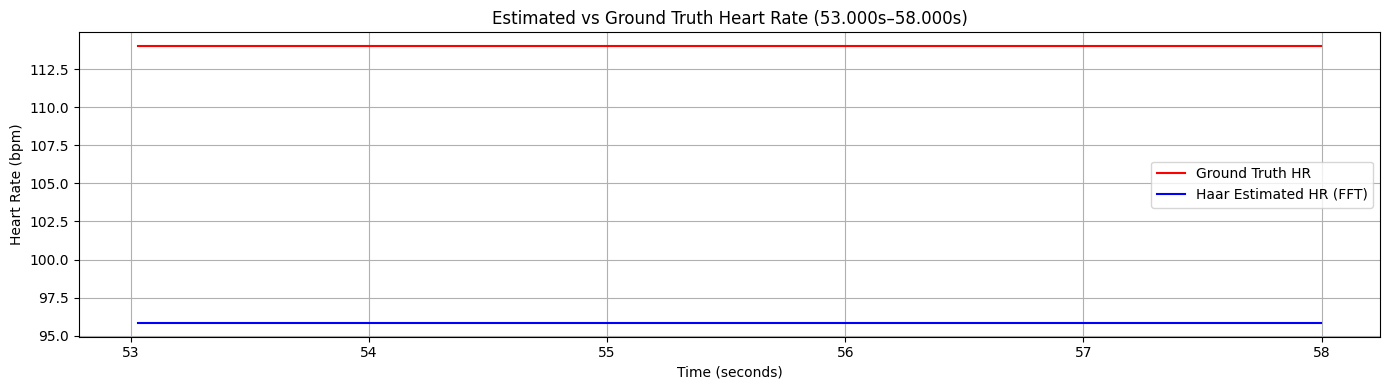

In [20]:
magn_test = fft(filtered_test)
freq_test = fftfreq(len(filtered_test), d=1/fps)

idxs = np.where(freq_test > 0)
freq_test = freq_test[idxs]
magn_test = np.abs(magn_test[idxs])

plt.figure(figsize=(15, 4))
plt.plot(freq_test, magn_test, color='teal')
plt.title("FFT of of Haar ROI Mean Intensity")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim([0,8])
plt.grid(True)
plt.tight_layout()
plt.show()

peak_freq_test = freq_test[np.argmax(magn_test)]
dominant_hr_test = peak_freq_test * 60
print(f"\nEstimated Heart Rate: {dominant_hr_test:.2f} bpm")


start_samp = np.searchsorted(gt_time, start_time)
end_samp = np.searchsorted(gt_time, end_time)
dominant_hr_test = np.full_like(gt_time[start_samp:end_samp], dominant_hr_test)

print(f"Ground Truth Heart Rate: {gt_hr[start_samp]} bpm\n")

plt.figure(figsize=(14, 4))
plt.plot(gt_time[start_samp:end_samp], gt_hr[start_samp:end_samp], color='r',
         label = 'Ground Truth HR')
plt.plot(gt_time[start_samp:end_samp], dominant_hr_test, color='b',
         label = 'Haar Estimated HR (FFT)')
plt.title(f"Estimated vs Ground Truth Heart Rate ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Heart Rate (bpm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Επομένως, η αρχική υπόθεση ότι η καρδιακή συχνότητα είναι 114 bpm δεν ισχύει και επομένως το Ground Truth εμφανίζει σφάλμα στα 53-58 sec.

### **2. Αδυναμία Μεθόδου**

Η διαδικασία εκτίμησης του καρδιακού ρυθμού που παρουσιάζεται στο *Μέρος 2*, αν και παρουσιάζει αρκετά καλά αποτελέσματα στο συγκεκριμένο υποκείμενο, επηρεάζεται σημαντικότατα από τις συνθήκες φωτισμού.
Χαρακτηριστικό παράδειγμα αποτελεί το υποκείμενο 11 του UBFC-RPPG Dataset 1.  

Στο βίντεο αυτού του Subject, ο φωτισμός του χώρου άλλαξε σε 3 διαφορετικά στιγμιότυπα κατά την διάρκεια της λήψης (στην αρχή, μέση και τέλος). Παρόλο λοιπόν που το υποκείμενο ήταν ακίνητο και όλοι οι υπόλοιποι παράγοντες φαίνεται να μην επηρεάζονται, τα συμβάντα αυτά οδηγούν, όπως φαίνεται και παρακάτω, σε λάθος εκτιμήσεις, έστω και στιγμιαία.

1) Καθορισμός των directoriew όλων των δεδομένων. Τύπωση χρήσιμων πληροφοριών σχετικά με το βίντεο του υποκειμένου και τύπωση του πρώτου frame ως δείγμα.

============ Video Info ============

Resolution:       640 x 480
Frame Rate (FPS): 28.672
Frame Count:      2300
Duration:         1:20.218 (80.218s)




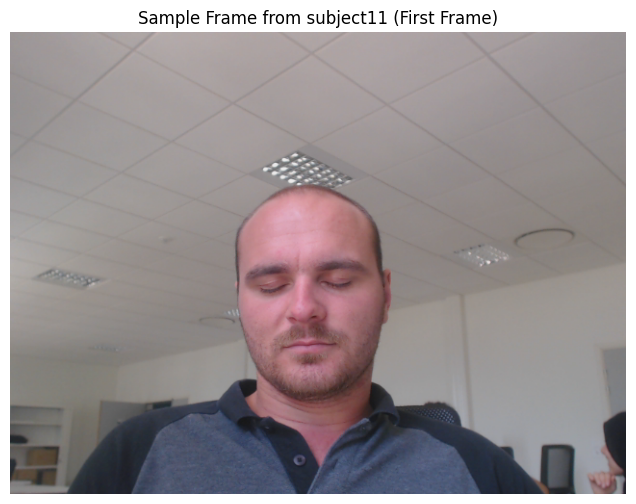

In [21]:
# UBFC-RPPG Dataset 1   (11-gt)
num = '11'

subject_path = f'/content/{num}-gt'
video_path = os.path.join(subject_path, 'vid.avi')
gt_path = os.path.join(subject_path, 'gtdump.xmp')


cap = cv2.VideoCapture(video_path)

ret, frame_bgr = cap.read()

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_duration_secs = frame_count / fps

cap.release()

frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

minutes = int(video_duration_secs // 60)
seconds = int(video_duration_secs % 60)
milliseconds = round((video_duration_secs - int(video_duration_secs)) * 1000)

video_duration_full_time = f"{minutes}:{seconds:02d}.{milliseconds:03d}"

print("============ Video Info ============\n")

print(f"Resolution:       {width} x {height}")
print(f"Frame Rate (FPS): {fps:.3f}")
print(f"Frame Count:      {frame_count}")
print(f"Duration:         {video_duration_full_time} ({video_duration_secs:.3f}s)\n")

print("====================================\n")

plt.figure(figsize=(8, 6))
plt.imshow(frame_rgb)
plt.title(f"Sample Frame from subject{num} (First Frame)")
plt.axis('off')
plt.show()

2) Τύπωση όλων των χρήσιμων πληροφοριών για το Ground Truth. Σχεδίαση της γραφικής παράστασης του PPG σήματος και του HR για ένα καθορισμένο χρονικό παράθυρο.

========= Ground Truth Info =========

PPG signal/Time/HR samples: 4991
Time range: 0.006s to 80.363s
Sampling rate (estimated): 62.098 Hz

PPG signal (first 10 samples): [57. 54. 51. 48. 45. 43. 43. 41. 41. 40.]
PPG signal mean: 40.243
PPG signal Standard Deviation: 17.562

Time in seconds (first 10 samples): [0.006 0.022 0.038 0.054 0.07  0.086 0.103 0.119 0.135 0.151]
Difference of sampling times (first 10 values): [0.016 0.016 0.016 0.016 0.016 0.017 0.016 0.016 0.016 0.016]
Difference of sampling times mean: 0.016
Difference of sampling times Standard Deviation: 0.000

Time difference of PPG peaks (first 10 samples): [0.757 0.741 0.789 0.805 0.821 0.821 0.805 0.79  0.789 0.756]\ν
HR in bpm (first 10 samples): [75 75 75 75 75 75 75 75 75 75]
HR mean: 77.705
HR Standard Deviation: 1.954




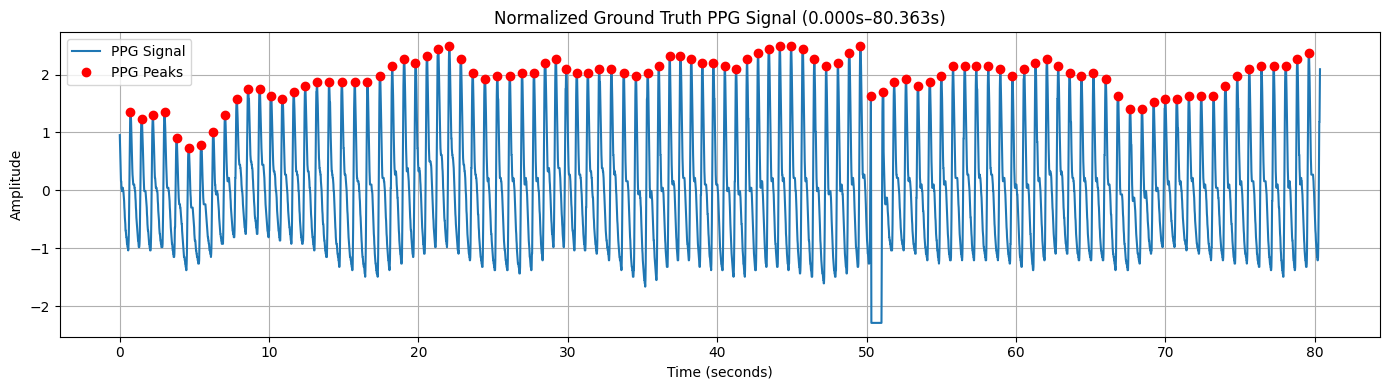

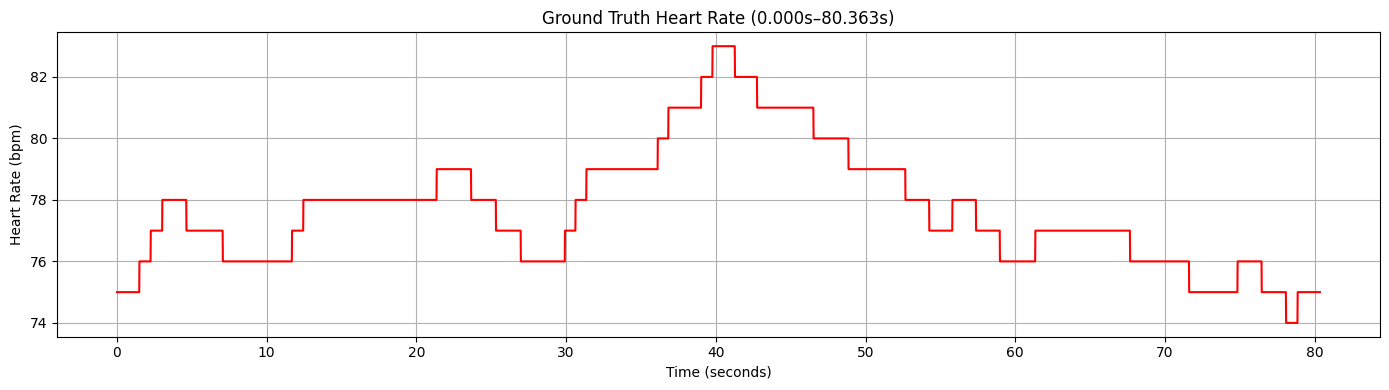

In [22]:
# UBFC-RPPG Dataset 1   (11-gt)
gt_data = np.genfromtxt(gt_path, delimiter=',')
gt_ppg = gt_data[:, 3]
gt_hr = gt_data[:, 1]
gt_time = gt_data[:, 0] / 1000.0


start_time = 0
segment_duration = gt_time[-1]

end_time = start_time + segment_duration
start_time = np.clip(start_time, 0, gt_time[-1])
end_time = np.clip(end_time, 0, gt_time[-1])

start_samp = np.searchsorted(gt_time, start_time)
end_samp = np.searchsorted(gt_time, end_time)

gt_ppg_norm = (gt_ppg - np.mean(gt_ppg)) / np.std(gt_ppg)
gt_ppg_peaks, gt_ppg_peaks_props = find_peaks(gt_ppg_norm,prominence=0.5)
gt_ppg_peak_times = gt_time[gt_ppg_peaks]

gt_samp_time_diff = np.diff(gt_time)
gt_peak_time_diff = np.diff(gt_ppg_peak_times)

gt_ppg_peaks_filt = gt_ppg_peaks[
    (gt_time[gt_ppg_peaks] >= start_time) &
    (gt_time[gt_ppg_peaks] <= end_time)
]


print("========= Ground Truth Info =========\n")

print(f"PPG signal/Time/HR samples: {len(gt_ppg)}")
print(f"Time range: {gt_time[0]:.3f}s to {gt_time[-1]:.3f}s")
print(f"Sampling rate (estimated): {1/np.mean(np.diff(gt_time)):.3f} Hz\n")

print(f"PPG signal (first 10 samples): {np.round(gt_ppg[:10], 3)}")
print(f"PPG signal mean: {np.mean(gt_ppg):.3f}")
print(f"PPG signal Standard Deviation: {np.std(gt_ppg):.3f}\n")

print(f"Time in seconds (first 10 samples): {gt_time[:10]}")
print(f"Difference of sampling times (first 10 values): {gt_samp_time_diff[:10]}")
print(f"Difference of sampling times mean: {np.mean(gt_samp_time_diff):.3f}")
print(f"Difference of sampling times Standard Deviation: {np.std(gt_samp_time_diff):.3f}\n")

print(f"Time difference of PPG peaks (first 10 samples): {gt_peak_time_diff[:10]}\ν")

print(f"HR in bpm (first 10 samples): {gt_hr[:10].astype(int)}")
print(f"HR mean: {np.mean(gt_hr):.3f}")
print(f"HR Standard Deviation: {np.std(gt_hr):.3f}\n")

print("=====================================\n")


plt.figure(figsize=(14, 4))
plt.plot(gt_time[start_samp:end_samp], gt_ppg_norm[start_samp:end_samp],
         label="PPG Signal")
plt.plot(gt_time[gt_ppg_peaks_filt], gt_ppg_norm[gt_ppg_peaks_filt], 'o',
         color = 'r', label="PPG Peaks")
plt.title(f"Normalized Ground Truth PPG Signal ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(gt_time[start_samp:end_samp], gt_hr[start_samp:end_samp], color='r',
         label = 'Ground Truth HR')
plt.title(f"Ground Truth Heart Rate ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Heart Rate (bpm)")
plt.grid(True)
plt.tight_layout()
plt.show()

3) Χειροκίνητος ορισμός της Region of Interest (ROI) για κάθε frame του βίντεο. Υπολογισμός για κάθε frame της μέσης έντασης ενός χρωματικού καναλιού (πράσινο - G) μέσα στην ROI (Spatial Averaging) και αναπαράσταση της σε γράφημα για όλο το χρονικό διάστημα.

In [23]:
start_time = 0
segment_duration = video_duration_secs

# UBFC-RPPG Dataset 1   (11-gt)
x1, y1 = 277, 198
x2, y2 = 329, 224
channel = 1  # 1: Green

end_time = start_time + segment_duration
start_time = np.clip(start_time, 0, video_duration_secs)
end_time = np.clip(end_time, 0, video_duration_secs)

start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

roi_coordinates = [x1, y1, x2, y2]
print(f'Manual ROI coordinates: Top Right ({x1},{y1}) - Bottom Left ({x2},{y2})')
print(f'Manual ROI size: {x2-x1} x {y2-y1}\n')
print('Calculating ROI Mean Channel Intensity in the respective video frames...\n')

roi_means_test, roi_frames_test = mean_intensity_manual_roi(video_path,
                                                                start_frame,
                                                                end_frame,
                                                                roi_coordinates,
                                                                channel
                                                                )

print('\n\nCalculations completed!')

Manual ROI coordinates: Top Right (277,198) - Bottom Left (329,224)
Manual ROI size: 52 x 26

Calculating ROI Mean Channel Intensity in the respective video frames...



100%|██████████| 2300/2300 [00:11<00:00, 191.90it/s]



Calculations completed!


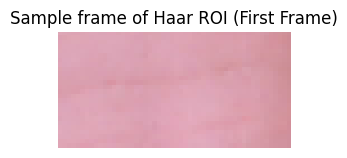

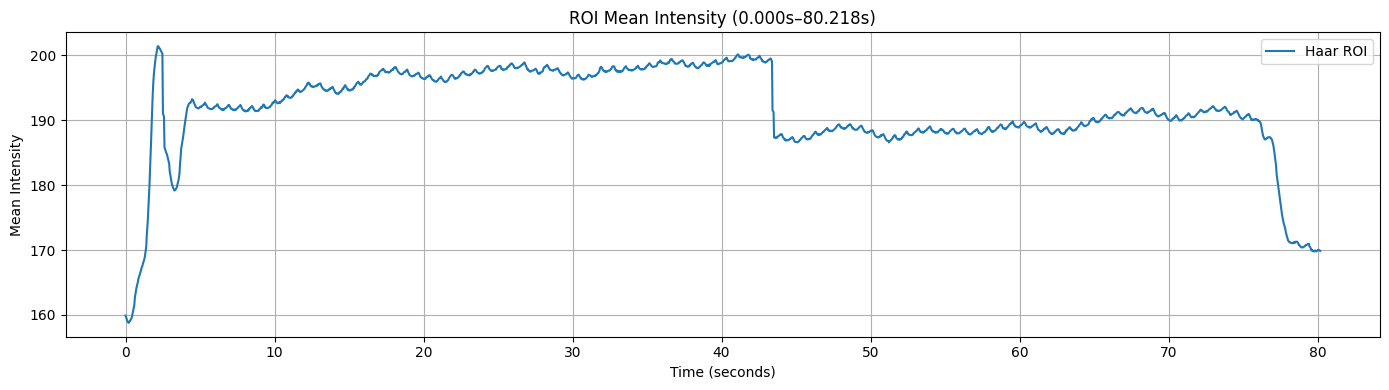

In [24]:
plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(roi_frames_test[0], cv2.COLOR_BGR2RGB))
plt.title(f"Sample frame of Haar ROI (First Frame)")
plt.axis('off')
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(np.arange(start_frame, start_frame + len(roi_means_test)) / fps,
         roi_means_test, label="Haar ROI")
plt.title(f"ROI Mean Intensity ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Όπως φαίνεται στο ακριβώς από πάνω διάγραμμα, υπάρχει σημαντική αλλαγή της μέσης έντασης των pixel της ROI στις τρεις χρονικές στιγμές που άλλαξε η φωτεινότητα του χώρου στο βίντεο.

4) Κανονικοποίηση (=> μ=0, σ=1) του σήματος μέσης έντασης για την αφαίρεση της DC συνιστώσας.

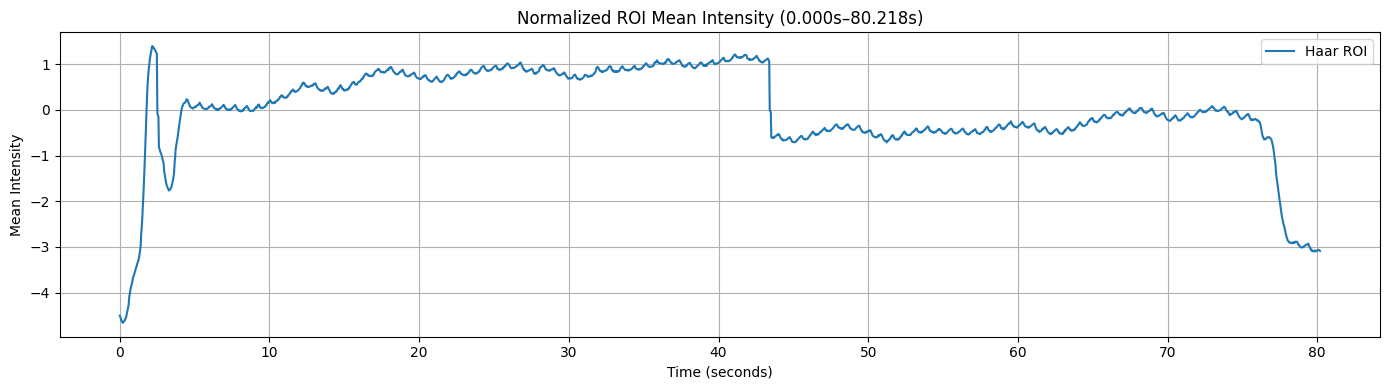

In [25]:
roi_mean_test_norm = (roi_means_test - np.mean(roi_means_test)) / np.std(roi_means_test)

plt.figure(figsize=(14, 4))
plt.plot(np.arange(int(start_time * fps), int(start_time * fps) + len(roi_means_test)) / fps,
         roi_mean_test_norm, label="Haar ROI")
plt.title(f"Normalized ROI Mean Intensity ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

5) Εφαρμογή Butterworth Ζωνοπερατού φίλτρου για την απομόνωση των ανθρώπινων καρδιακών συχνοτήτων

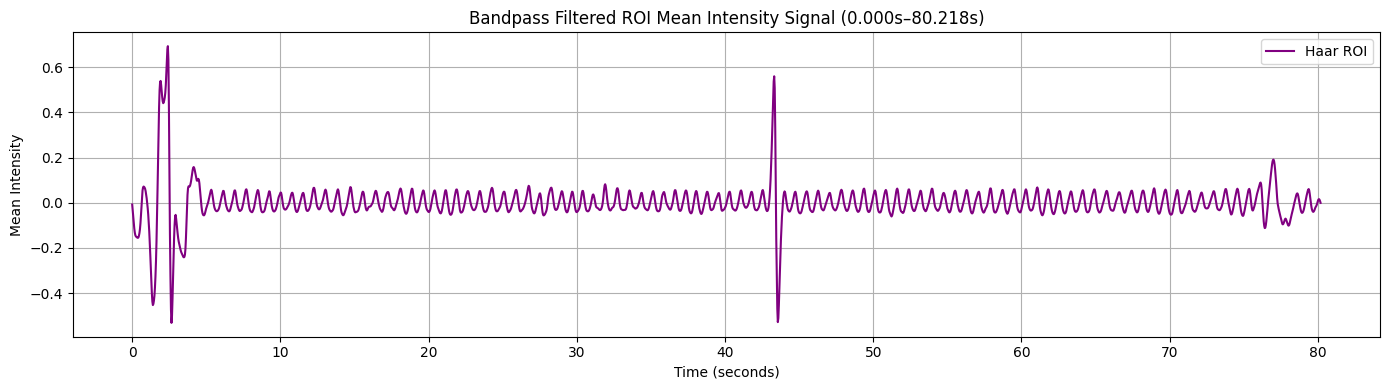

In [26]:
lowcut = 0.75
highcut = 3.5
filt_order=1

filtered_test = bandpass_filter(roi_mean_test_norm, lowcut, highcut, fps, filt_order)

plt.figure(figsize=(14, 4))
plt.plot(np.arange(int(start_time * fps), int(start_time * fps) + len(roi_mean_test_norm)) / fps,
         filtered_test, color='purple', label="Haar ROI")
plt.title(f"Bandpass Filtered ROI Mean Intensity Signal ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Είναι ξεκάθαρο ότι ακόμη και μετά την εφαρμογή του ζωνοπερατού φίλτρου, η αλλαγή της έντασης έχει αρκετά σημαντικό αντίκτυπο στο τελικό σήμα.

6) Εφαρμογή Short-Time-Fourier-Transform στο φιλτραρισμένο σήμα και οπτικοποίηση του μετασχηματισμού μέσω Spectogram. Εξαγαγωγή της κυρίαρχης συχνότητας από το κάθε χρονικό παράθυρο, μετατροπή από Hz σε bpm και αναπαράσταση σε γράφημα συγκριτικά με το HR του Ground Truth.

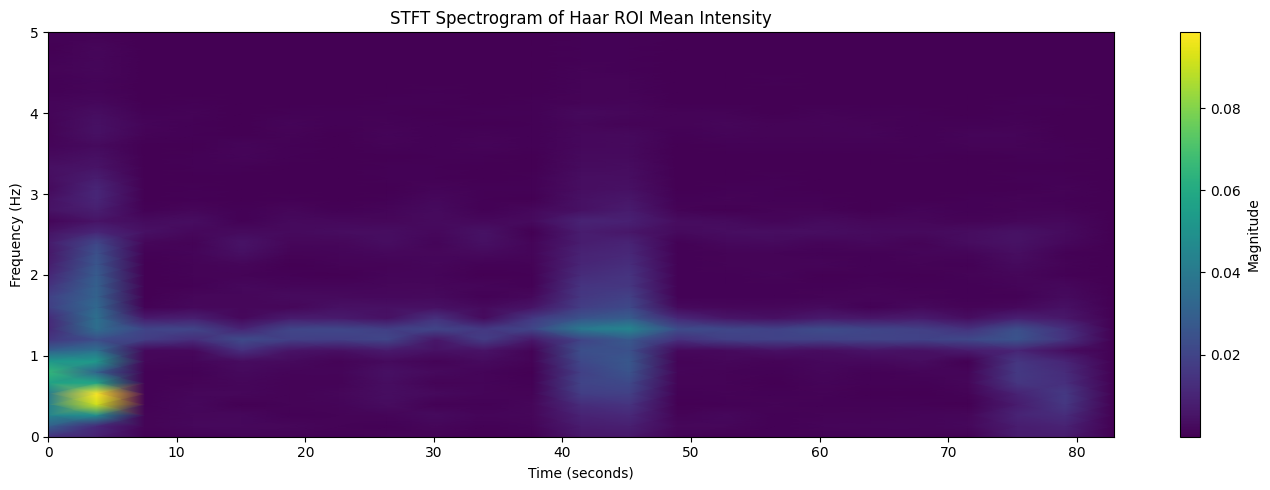

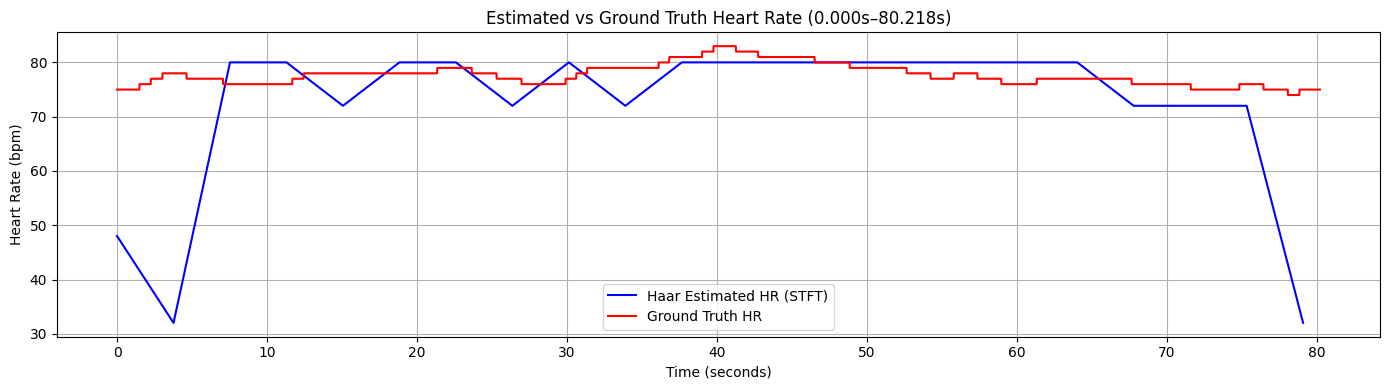

In [27]:
# Input the window parameters for the STFT
# ----------------------
window_size = 215
overlap_ratio = 0.5
# ----------------------



f_test, t_test, Zxx_test = stft(filtered_test,
                                fs=fps,
                                nperseg=window_size,
                                noverlap= int(overlap_ratio * window_size),
                                # boundary=None,
                                # padded=False,
                                )

t_test = t_test + start_time
magnitude_test = np.abs(Zxx_test)
dominant_freqs_test = f_test[np.argmax(magnitude_test, axis=0)]
dominant_hr_test = dominant_freqs_test * 60  # Hz to bpm

valid_idx = t_test <= end_time
t_test_valid = t_test[valid_idx]
dominant_hr_test_valid = dominant_hr_test[valid_idx]

start_samp = np.searchsorted(gt_time, start_time)
end_samp = np.searchsorted(gt_time, end_time)

plt.figure(figsize=(14, 5))
plt.pcolormesh(t_test, f_test, magnitude_test, shading='gouraud')
plt.title("STFT Spectrogram of Haar ROI Mean Intensity")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='Magnitude')
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(t_test_valid, dominant_hr_test_valid, color='blue', label='Haar Estimated HR (STFT)')
# plt.plot(t_test, dominant_hr_test, color='blue', label='Estimated HR (STFT)')
plt.plot(gt_time[start_samp:end_samp], gt_hr[start_samp:end_samp], color='red', label='Ground Truth HR')
plt.title(f"Estimated vs Ground Truth Heart Rate ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Heart Rate (bpm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Από το spectogram φαίνεται ότι οι χρονικές στιγμές αλλαγής του φωτισμού επηρεάζουν την τελική εκτίμηση. Αν και η αλλαγή στα 43sec δεν κατάφερε να υπερισχύσει, οι υπόλοιπες οδήγησαν σε λάθος υπολογισμό HR.

Αξίζει βέβαια να σημειωθεί ότι η επηρροή των αλλαγών στο τελικό σήμα εξαρτάται και από το μέγεθος του παραθύρου του STFT. Αν το παράθυρο είναι αρκετά μεγάλο ώστε η συχνότητα που αντιστοιχεί στο σφάλμα να αποτελεί την "μειοψηφία", τότε η αλλαγή δεν επηρεάζει την εκτίμηση. Αυτό όμως έρχεται με trade off την ακρίβεια και την ανάλυση της μέτρησης.